In [ ]:
pip install torch torchvision pandas pillow scikit-learn matplotlib


In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random


In [2]:
df = pd.read_csv("datasets/final_dataset_ready.csv")

# Encode labels if not already ints
if df['label'].dtype != np.int64 and df['label'].dtype != np.int32:
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
else:
    label_encoder = None  # Already encoded

print("Sample rows:")
print(df.head())


Sample rows:
                                           file_path      emotion  source  \
0  /Users/yaseenshaikh/Desktop/IEEE Research/data...        worry  emo135   
1  /Users/yaseenshaikh/Desktop/IEEE Research/data...    affection  emo135   
2  /Users/yaseenshaikh/Desktop/IEEE Research/data...     surprise     ck+   
3  /Users/yaseenshaikh/Desktop/IEEE Research/data...  frustration  emo135   
4  /Users/yaseenshaikh/Desktop/IEEE Research/data...  frustration  emo135   

   label  
0     11  
1      0  
2     10  
3      7  
4      7  


In [3]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Validation: {len(val_df)}")


Train: 720 | Validation: 180


In [4]:
class MixedEmotionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        label = int(row['label'])
        image = Image.open(img_path).convert('L')  # Grayscale

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MixedEmotionDataset(train_df, transform=transform_train)
val_dataset = MixedEmotionDataset(val_df, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (32, 24, 24)
        x = self.pool(F.relu(self.conv2(x)))   # (64, 12, 12)
        x = self.pool(F.relu(self.conv3(x)))   # (128, 6, 6)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [7]:
num_classes = df['label'].nunique()
print("Number of classes:", num_classes)


Number of classes: 12


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
num_epochs = 15

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss/train_total:.4f} | Train Acc: {train_correct/train_total:.4f} "
          f"| Val Loss: {val_loss/val_total:.4f} | Val Acc: {val_correct/val_total:.4f}")


Epoch [1/15] Train Loss: 2.1968 | Train Acc: 0.1903 | Val Loss: 1.8975 | Val Acc: 0.2389
Epoch [2/15] Train Loss: 1.8743 | Train Acc: 0.2264 | Val Loss: 1.6979 | Val Acc: 0.2944
Epoch [3/15] Train Loss: 1.6594 | Train Acc: 0.3167 | Val Loss: 1.5445 | Val Acc: 0.3667
Epoch [4/15] Train Loss: 1.5202 | Train Acc: 0.3736 | Val Loss: 1.4925 | Val Acc: 0.4500
Epoch [5/15] Train Loss: 1.4216 | Train Acc: 0.4222 | Val Loss: 1.4072 | Val Acc: 0.4389
Epoch [6/15] Train Loss: 1.3187 | Train Acc: 0.4778 | Val Loss: 1.3604 | Val Acc: 0.4222
Epoch [7/15] Train Loss: 1.2855 | Train Acc: 0.4819 | Val Loss: 1.3603 | Val Acc: 0.4333
Epoch [8/15] Train Loss: 1.1887 | Train Acc: 0.5292 | Val Loss: 1.3164 | Val Acc: 0.4556
Epoch [9/15] Train Loss: 1.1327 | Train Acc: 0.5444 | Val Loss: 1.2950 | Val Acc: 0.5111
Epoch [10/15] Train Loss: 1.0817 | Train Acc: 0.5667 | Val Loss: 1.2328 | Val Acc: 0.5222
Epoch [11/15] Train Loss: 1.0376 | Train Acc: 0.5833 | Val Loss: 1.2253 | Val Acc: 0.4833
Epoch [12/15] Train

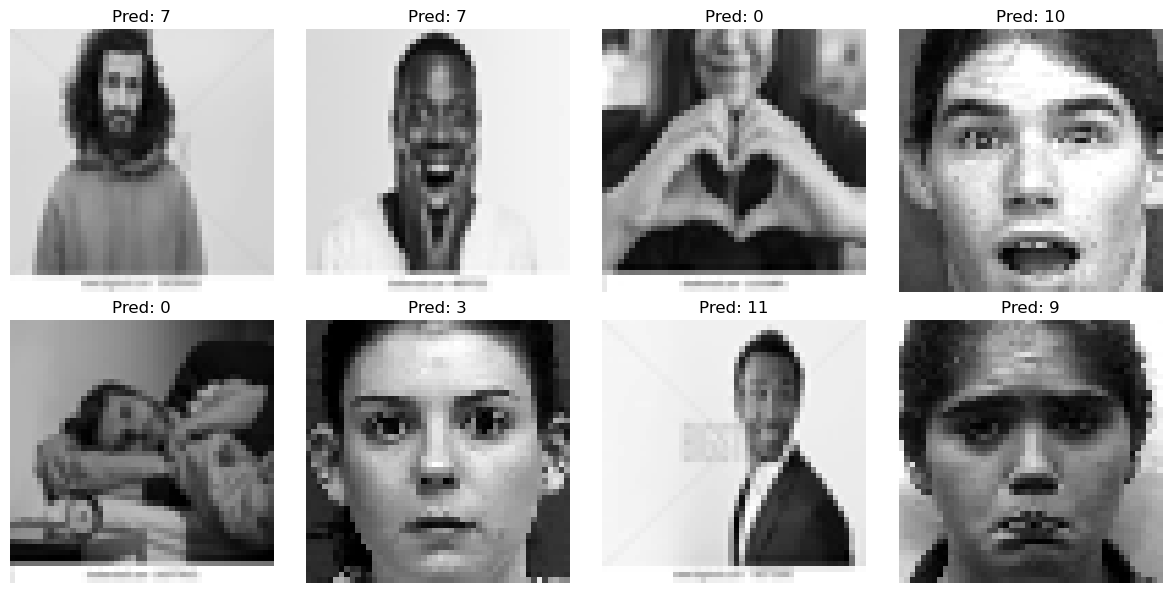

In [10]:
model.eval()
sample_images, sample_labels = next(iter(val_loader))
with torch.no_grad():
    sample_images = sample_images.to(device)
    outputs = model(sample_images)
    _, preds = torch.max(outputs, 1)
    
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(sample_images[i].cpu().squeeze(), cmap='gray')
    label_text = preds[i].cpu().item()
    if label_encoder is not None:
        label_text = label_encoder.inverse_transform([label_text])[0]
    plt.title(f"Pred: {label_text}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("final_dataset_ready.csv")  # path as needed

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class EmotionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img = Image.open(row['file_path']).convert('L')  # grayscale
        label = int(row['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

# Use strong augmentation for train, light for val
train_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = EmotionDataset(train_df, transform=train_transform)
val_dataset = EmotionDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)



In [17]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet18 and adapt to grayscale
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 channel input
num_classes = df['label'].nunique()
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18.fc.in_features, num_classes)
)

model = resnet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


In [19]:
best_acc = 0
for epoch in range(30):  # try 30-50 for best results
    model.train()
    train_loss, train_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
    train_acc = train_correct / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    val_acc = val_correct / len(val_loader.dataset)
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss/len(train_loader.dataset):.4f} | Val Loss: {val_loss/len(val_loader.dataset):.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_emotion_model.pt")

print("Best Validation Accuracy:", best_acc)


Epoch 1 | Train Acc: 0.2157 | Val Acc: 0.1852 | Train Loss: 2.5318 | Val Loss: 2.4651
Epoch 2 | Train Acc: 0.3007 | Val Acc: 0.3852 | Train Loss: 1.9061 | Val Loss: 1.7566
Epoch 3 | Train Acc: 0.3333 | Val Acc: 0.3407 | Train Loss: 1.7970 | Val Loss: 1.8626
Epoch 4 | Train Acc: 0.3791 | Val Acc: 0.3704 | Train Loss: 1.6713 | Val Loss: 1.4717
Epoch 5 | Train Acc: 0.4170 | Val Acc: 0.4444 | Train Loss: 1.5482 | Val Loss: 1.4021
Epoch 6 | Train Acc: 0.4078 | Val Acc: 0.4667 | Train Loss: 1.5684 | Val Loss: 1.3895
Epoch 7 | Train Acc: 0.4484 | Val Acc: 0.4444 | Train Loss: 1.4023 | Val Loss: 1.3133
Epoch 8 | Train Acc: 0.4418 | Val Acc: 0.3778 | Train Loss: 1.4282 | Val Loss: 1.4962
Epoch 9 | Train Acc: 0.4824 | Val Acc: 0.4963 | Train Loss: 1.4266 | Val Loss: 1.3026
Epoch 10 | Train Acc: 0.4850 | Val Acc: 0.5333 | Train Loss: 1.3369 | Val Loss: 1.3200
Epoch 11 | Train Acc: 0.4902 | Val Acc: 0.3704 | Train Loss: 1.3484 | Val Loss: 1.6158
Epoch 12 | Train Acc: 0.5229 | Val Acc: 0.5333 | Tra

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/yaseenshaikh/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:02<00:00, 8.17MB/s]


NameError: name 'NUM_CLASSES' is not defined

In [31]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cpu


In [32]:
CSV_PATH = 'datasets/final_dataset_ready.csv'   # Path to your clean, merged CSV
NUM_CLASSES = 12                                # Since your labels are 0–11

df = pd.read_csv(CSV_PATH)
# Sanity check: you should see all labels 0–11
print(np.unique(df['label']), df['label'].value_counts())


[ 0  1  2  3  4  5  6  7  8  9 10 11] label
11    100
7     100
1     100
3     100
4     100
0      91
10     83
8      69
5      59
2      45
9      28
6      25
Name: count, dtype: int64


In [33]:
train_transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(48, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [34]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['file_path']).convert('L')
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label


In [35]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print("Train:", train_df.shape, "Val:", val_df.shape)

train_dataset = EmotionDataset(train_df, transform=train_transform)
val_dataset = EmotionDataset(val_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


Train: (720, 4) Val: (180, 4)


In [36]:
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.arange(NUM_CLASSES),
                                    y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)
print('Class weights:', class_weights)


Class weights: tensor([0.8219, 0.7500, 1.6667, 0.7500, 0.7500, 1.2766, 3.0000, 0.7500, 1.0909,
        2.6087, 0.9091, 0.7500])


In [37]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # 1 channel (grayscale)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)


In [38]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)


Epoch  1 | Train Acc: 0.1917 | Val Acc: 0.1056 | Train Loss: 2.4517 | Val Loss: 3.0763 | Prec: 0.0301 | Rec: 0.0792 | F1: 0.0310
Epoch  2 | Train Acc: 0.2694 | Val Acc: 0.1222 | Train Loss: 2.2163 | Val Loss: 3.4497 | Prec: 0.1261 | Rec: 0.0952 | F1: 0.0631
Epoch  3 | Train Acc: 0.3139 | Val Acc: 0.1278 | Train Loss: 2.0317 | Val Loss: 2.6733 | Prec: 0.1668 | Rec: 0.1197 | F1: 0.0968
Epoch  4 | Train Acc: 0.3556 | Val Acc: 0.2222 | Train Loss: 1.9651 | Val Loss: 2.3699 | Prec: 0.3208 | Rec: 0.2527 | F1: 0.2005
Epoch  5 | Train Acc: 0.3722 | Val Acc: 0.3611 | Train Loss: 1.9070 | Val Loss: 1.9534 | Prec: 0.4722 | Rec: 0.3723 | F1: 0.3469
Epoch  6 | Train Acc: 0.4111 | Val Acc: 0.4000 | Train Loss: 1.8456 | Val Loss: 1.8664 | Prec: 0.4344 | Rec: 0.4196 | F1: 0.3927
Epoch  7 | Train Acc: 0.4139 | Val Acc: 0.3500 | Train Loss: 1.7660 | Val Loss: 1.9327 | Prec: 0.3521 | Rec: 0.3634 | F1: 0.3229
Epoch  8 | Train Acc: 0.4542 | Val Acc: 0.4111 | Train Loss: 1.7608 | Val Loss: 1.8139 | Prec: 0.

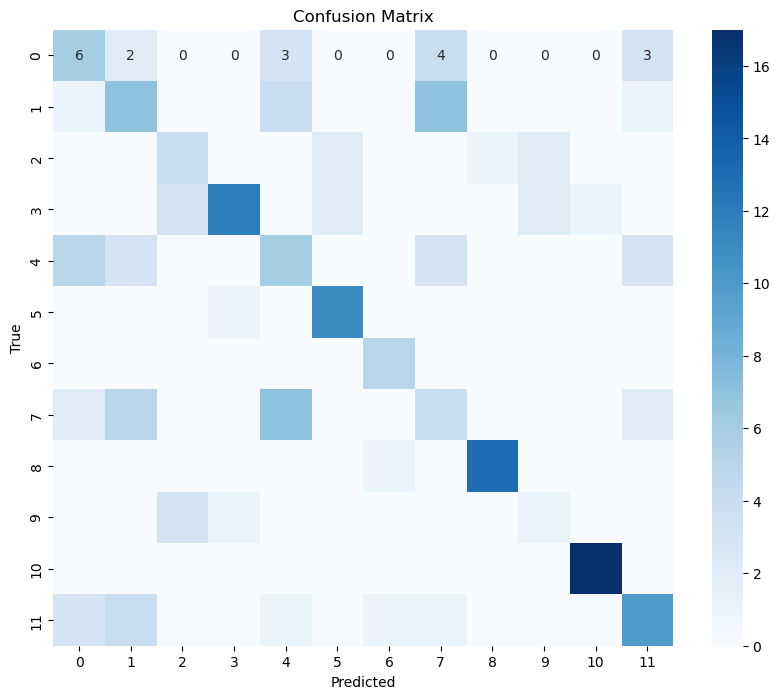

In [39]:
epochs = 30
best_val_acc = 0

def evaluate(loader):
    model.eval()
    all_labels, all_preds = [], []
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    val_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds  = np.concatenate(all_preds)
    val_acc = (all_preds == all_labels).mean()
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec  = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1   = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return val_loss, val_acc, prec, rec, f1, all_labels, all_preds

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    val_loss, val_acc, prec, rec, f1, y_true, y_pred = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_emotion_model.pt')

# Final metrics/report
model.load_state_dict(torch.load('best_emotion_model.pt'))
_, _, prec, rec, f1, y_true, y_pred = evaluate(val_loader)
print("\nClassification Report:\n", classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [50]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")

# Set reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [51]:
# Update your dataset path and number of classes
CSV_PATH = 'datasets/final_dataset_ready.csv'
NUM_CLASSES = 12  # You said your labels go from 0 to 11

df = pd.read_csv(CSV_PATH)
print(df['label'].value_counts())  # Always check class balance!


label
11    100
7     100
1     100
3     100
4     100
0      91
10     83
8      69
5      59
2      45
9      28
6      25
Name: count, dtype: int64


In [52]:
train_transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.35, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(48, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [53]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['file_path']).convert('L')
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label


In [54]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = EmotionDataset(train_df, transform=train_transform)
val_dataset   = EmotionDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [55]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [56]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)


In [57]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.08)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)


In [58]:
def evaluate(loader):
    model.eval()
    all_labels, all_preds = [], []
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    val_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds  = np.concatenate(all_preds)
    val_acc = (all_preds == all_labels).mean()
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec  = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1   = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return val_loss, val_acc, prec, rec, f1, all_labels, all_preds

epochs = 40
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    val_loss, val_acc, prec, rec, f1, y_true, y_pred = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_emotion_model.pt')

print("\nBest Validation Accuracy: {:.4f}".format(best_val_acc))


Epoch  1 | Train Acc: 0.1292 | Val Acc: 0.1278 | Train Loss: 2.5324 | Val Loss: 2.9475 | Prec: 0.0641 | Rec: 0.0958 | F1: 0.0381
Epoch  2 | Train Acc: 0.2236 | Val Acc: 0.1222 | Train Loss: 2.2494 | Val Loss: 2.4311 | Prec: 0.1101 | Rec: 0.1273 | F1: 0.0917
Epoch  3 | Train Acc: 0.2389 | Val Acc: 0.1889 | Train Loss: 2.1972 | Val Loss: 2.3554 | Prec: 0.1921 | Rec: 0.1868 | F1: 0.1651
Epoch  4 | Train Acc: 0.2792 | Val Acc: 0.3056 | Train Loss: 2.1206 | Val Loss: 2.1184 | Prec: 0.2894 | Rec: 0.2870 | F1: 0.2601
Epoch  5 | Train Acc: 0.3236 | Val Acc: 0.3000 | Train Loss: 1.9714 | Val Loss: 2.0197 | Prec: 0.2970 | Rec: 0.2953 | F1: 0.2740
Epoch  6 | Train Acc: 0.3583 | Val Acc: 0.3167 | Train Loss: 1.9335 | Val Loss: 2.0690 | Prec: 0.2879 | Rec: 0.2888 | F1: 0.2582
Epoch  7 | Train Acc: 0.3639 | Val Acc: 0.3333 | Train Loss: 1.8926 | Val Loss: 2.0303 | Prec: 0.3395 | Rec: 0.3191 | F1: 0.3015
Epoch  8 | Train Acc: 0.3681 | Val Acc: 0.3722 | Train Loss: 1.8303 | Val Loss: 2.1327 | Prec: 0.

In [59]:
  import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [60]:
CSV_PATH = 'datasets/final_dataset_ready.csv'
NUM_CLASSES = 12
df = pd.read_csv(CSV_PATH)

train_transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # for 3 channels
])

val_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['file_path']).convert('L').convert('RGB')  # duplicate to 3 channels
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label


In [61]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = EmotionDataset(train_df, train_transform)
val_dataset = EmotionDataset(val_df, val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [62]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)


In [64]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.08)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [65]:
def evaluate(loader):
    model.eval()
    all_labels, all_preds = [], []
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    val_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds  = np.concatenate(all_preds)
    val_acc = (all_preds == all_labels).mean()
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec  = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1   = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return val_loss, val_acc, prec, rec, f1, all_labels, all_preds

epochs = 40
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    val_loss, val_acc, prec, rec, f1, y_true, y_pred = evaluate(val_loader)
    scheduler.step()
    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_emotion_model.pt')

print("\nBest Validation Accuracy: {:.4f}".format(best_val_acc))


Epoch  1 | Train Acc: 0.1653 | Val Acc: 0.2500 | Train Loss: 2.6620 | Val Loss: 2.4706 | Prec: 0.2211 | Rec: 0.2531 | F1: 0.1861
Epoch  2 | Train Acc: 0.2931 | Val Acc: 0.3722 | Train Loss: 2.1111 | Val Loss: 2.0186 | Prec: 0.4274 | Rec: 0.3767 | F1: 0.3618
Epoch  3 | Train Acc: 0.3556 | Val Acc: 0.3222 | Train Loss: 1.8825 | Val Loss: 1.9419 | Prec: 0.3456 | Rec: 0.3446 | F1: 0.3028
Epoch  4 | Train Acc: 0.4319 | Val Acc: 0.3889 | Train Loss: 1.6761 | Val Loss: 1.8719 | Prec: 0.4482 | Rec: 0.4224 | F1: 0.3520
Epoch  5 | Train Acc: 0.4847 | Val Acc: 0.4667 | Train Loss: 1.5923 | Val Loss: 1.6615 | Prec: 0.4497 | Rec: 0.4868 | F1: 0.4469
Epoch  6 | Train Acc: 0.5278 | Val Acc: 0.3889 | Train Loss: 1.4481 | Val Loss: 1.7468 | Prec: 0.4051 | Rec: 0.4014 | F1: 0.3757
Epoch  7 | Train Acc: 0.5806 | Val Acc: 0.4444 | Train Loss: 1.3742 | Val Loss: 1.6749 | Prec: 0.4674 | Rec: 0.4657 | F1: 0.4312
Epoch  8 | Train Acc: 0.6347 | Val Acc: 0.5000 | Train Loss: 1.2832 | Val Loss: 1.6940 | Prec: 0.

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
import os

df = pd.read_csv('final_dataset_ready.csv')
print(df.head())
NUM_CLASSES = df['label'].nunique()
print("NUM_CLASSES:", NUM_CLASSES)


                                           file_path      emotion  source  \
0          datasets/emo135_images/image_emo_0000.png        worry  emo135   
1          datasets/emo135_images/image_emo_0001.png    affection  emo135   
2  /Users/yaseenshaikh/Desktop/IEEE Research/data...     surprise     ck+   
3          datasets/emo135_images/image_emo_0002.png  frustration  emo135   
4          datasets/emo135_images/image_emo_0003.png  frustration  emo135   

   label  
0     11  
1      0  
2     10  
3      7  
4      7  
NUM_CLASSES: 12


In [74]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print("Train size:", len(train_df), "Val size:", len(val_df))


Train size: 720 Val size: 180


In [75]:
train_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [76]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'file_path']
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        label = int(self.df.loc[idx, 'label'])
        return img, label


In [77]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [78]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [79]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # Single channel
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)


In [80]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)


In [81]:
def evaluate(loader):
    model.eval()
    all_labels, all_preds = [], []
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    val_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds  = np.concatenate(all_preds)
    val_acc = (all_preds == all_labels).mean()
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec  = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1   = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return val_loss, val_acc, prec, rec, f1, all_labels, all_preds

epochs = 50
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    val_loss, val_acc, prec, rec, f1, y_true, y_pred = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_emotion_model.pt')

# Load best model and print classification report
model.load_state_dict(torch.load('best_emotion_model.pt'))
_, _, prec, rec, f1, y_true, y_pred = evaluate(val_loader)
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Epoch  1 | Train Acc: 0.1458 | Val Acc: 0.1722 | Train Loss: 2.5313 | Val Loss: 2.5266 | Prec: 0.1127 | Rec: 0.1399 | F1: 0.1145
Epoch  2 | Train Acc: 0.2639 | Val Acc: 0.1444 | Train Loss: 2.2058 | Val Loss: 2.3823 | Prec: 0.1399 | Rec: 0.1524 | F1: 0.1117
Epoch  3 | Train Acc: 0.2917 | Val Acc: 0.2111 | Train Loss: 2.0677 | Val Loss: 2.2473 | Prec: 0.2002 | Rec: 0.2232 | F1: 0.1834
Epoch  4 | Train Acc: 0.3361 | Val Acc: 0.2611 | Train Loss: 1.9703 | Val Loss: 2.1689 | Prec: 0.2866 | Rec: 0.2871 | F1: 0.2466
Epoch  5 | Train Acc: 0.4000 | Val Acc: 0.3222 | Train Loss: 1.8451 | Val Loss: 2.1183 | Prec: 0.3266 | Rec: 0.3181 | F1: 0.2994
Epoch  6 | Train Acc: 0.4375 | Val Acc: 0.3611 | Train Loss: 1.7957 | Val Loss: 1.9660 | Prec: 0.3721 | Rec: 0.3484 | F1: 0.3478
Epoch  7 | Train Acc: 0.4806 | Val Acc: 0.3222 | Train Loss: 1.7121 | Val Loss: 1.9873 | Prec: 0.3859 | Rec: 0.3246 | F1: 0.3114
Epoch  8 | Train Acc: 0.4736 | Val Acc: 0.4444 | Train Loss: 1.6650 | Val Loss: 1.8761 | Prec: 0.

In [82]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
from PIL import Image

# 1. Load Data
df = pd.read_csv('final_dataset_ready.csv')

# 2. Prepare arrays for image and labels (use label column for 12 classes)
X = df['file_path'].to_numpy()
y = df['label'].to_numpy()  # <-- use label, not emotion!
num_classes = len(np.unique(y))

# 3. Split for stratified train/val
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)

# 4. Define PyTorch Dataset (loads grayscale images)
class ImageDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.x = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.x[index]
        # Loads as grayscale
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, int(self.y[index])

    def __len__(self):
        return len(self.x)

# 5. Augmentation and transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale -> 3 channels
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale -> 3 channels
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 6. Datasets and loaders
batch_size = 32
train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
val_dataset = ImageDataset(X_test, y_test, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. Compute class weights (for 12 classes!)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# 8. Model: ViT-L-32 (or you can use resnet50/efficientnet_b0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vit_l_32(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model = model.to(device)

# 9. Loss, optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 10. Training loop
epochs = 25
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# 11. Classification report
print(classification_report(all_labels, all_preds, digits=4))


Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to /Users/yaseenshaikh/.cache/torch/hub/checkpoints/vit_l_32-c7638314.pth
100%|██████████████████████████████████████| 1.14G/1.14G [03:00<00:00, 6.78MB/s]


Epoch 1 | Train Acc: 0.2861 | Val Acc: 0.5167
Epoch 2 | Train Acc: 0.6153 | Val Acc: 0.5556
Epoch 3 | Train Acc: 0.7444 | Val Acc: 0.5889
Epoch 4 | Train Acc: 0.8361 | Val Acc: 0.5389
Epoch 5 | Train Acc: 0.9139 | Val Acc: 0.5611
Epoch 6 | Train Acc: 0.9639 | Val Acc: 0.6056
Epoch 7 | Train Acc: 0.9736 | Val Acc: 0.5833
Epoch 8 | Train Acc: 0.9736 | Val Acc: 0.5944
Epoch 9 | Train Acc: 0.9819 | Val Acc: 0.5667
Epoch 10 | Train Acc: 0.9764 | Val Acc: 0.5667
Epoch 11 | Train Acc: 0.9917 | Val Acc: 0.5833
Epoch 12 | Train Acc: 0.9972 | Val Acc: 0.5722
Epoch 13 | Train Acc: 0.9931 | Val Acc: 0.6056
Epoch 14 | Train Acc: 0.9931 | Val Acc: 0.6111
Epoch 15 | Train Acc: 0.9972 | Val Acc: 0.6167
Epoch 16 | Train Acc: 0.9986 | Val Acc: 0.6111
Epoch 17 | Train Acc: 0.9917 | Val Acc: 0.5611
Epoch 18 | Train Acc: 0.9972 | Val Acc: 0.5889
Epoch 19 | Train Acc: 0.9986 | Val Acc: 0.5889
Epoch 20 | Train Acc: 0.9944 | Val Acc: 0.6056
Epoch 21 | Train Acc: 0.9972 | Val Acc: 0.5833
Epoch 22 | Train Acc: 

In [84]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
from PIL import Image

# 1. Load Data
df = pd.read_csv('final_dataset_ready.csv')
X = df['file_path'].to_numpy()
y = df['label'].to_numpy()
num_classes = len(np.unique(y))

# 2. Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Dataset Class (grayscale images)
class ImageDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.x = X
        self.y = y
        self.transform = transform
    def __getitem__(self, index):
        img_path = self.x[index]
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, int(self.y[index])
    def __len__(self):
        return len(self.x)

# 4. Strong Data Augmentation for Train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.9,1.1), shear=10)], p=0.7),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale -> 3 channels
    transforms.Normalize([0.5]*3, [0.5]*3),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# 5. Loaders
batch_size = 32
train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
val_dataset = ImageDataset(X_val, y_val, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 6. Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# 7. Model: ViT-L-32 with Extra Dropout
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vit_l_32(pretrained=True)
model.heads.head = nn.Sequential(
    nn.Dropout(0.4),  # Extra dropout
    nn.Linear(model.heads.head.in_features, num_classes)
)
model = model.to(device)

# 8. Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=4, factor=0.4, verbose=True)

# 9. Early Stopping
best_val_acc = 0
patience, bad_epochs = 10, 0
best_model_wts = None

# 10. Mixup/CutMix (for regularization)
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha <= 0:
        return x, y, 1
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 11. Training Loop with Mixup, Early Stopping, and Model Save
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if random.random() > 0.3:  # Mixup with 70% chance
            mixed_imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=0.3)
            outputs = model(mixed_imgs)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            preds = outputs.max(1)[1]
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = outputs.max(1)[1]
            correct += preds.eq(labels).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        total += labels.size(0)
    train_acc = correct / total

    # --- Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_acc = val_correct / val_total
    scheduler.step(val_acc)
    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # --- Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1
    if bad_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 12. Load Best Model, Final Test
model.load_state_dict(best_model_wts)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))


Epoch  1 | Train Acc: 0.1726 | Val Acc: 0.2389
Epoch  2 | Train Acc: 0.3536 | Val Acc: 0.4444
Epoch  3 | Train Acc: 0.4129 | Val Acc: 0.5222
Epoch  4 | Train Acc: 0.5420 | Val Acc: 0.5389
Epoch  5 | Train Acc: 0.5987 | Val Acc: 0.5444
Epoch  6 | Train Acc: 0.6418 | Val Acc: 0.5778
Epoch  7 | Train Acc: 0.7019 | Val Acc: 0.5889
Epoch  8 | Train Acc: 0.6838 | Val Acc: 0.5611
Epoch  9 | Train Acc: 0.7064 | Val Acc: 0.5611
Epoch 10 | Train Acc: 0.6955 | Val Acc: 0.6111
Epoch 11 | Train Acc: 0.8112 | Val Acc: 0.6167
Epoch 12 | Train Acc: 0.7928 | Val Acc: 0.5944
Epoch 13 | Train Acc: 0.7921 | Val Acc: 0.6111
Epoch 14 | Train Acc: 0.8482 | Val Acc: 0.6056
Epoch 15 | Train Acc: 0.8360 | Val Acc: 0.6000
Epoch 16 | Train Acc: 0.8288 | Val Acc: 0.6167
Epoch 17 | Train Acc: 0.8459 | Val Acc: 0.6056
Epoch 18 | Train Acc: 0.8722 | Val Acc: 0.6056
Epoch 19 | Train Acc: 0.8752 | Val Acc: 0.6167
Epoch 20 | Train Acc: 0.8107 | Val Acc: 0.6222
Epoch 21 | Train Acc: 0.9160 | Val Acc: 0.6167
Epoch 22 | Tr